In [255]:
import numpy as np
import pandas as pd
import requests
import io
import networkx as nx
import epyc
from mpmath import polylog as Li   # use standard name
import math
import pycountry
import datetime
import pymc3 as pm
import scipy.stats
import scipy.optimize
import seaborn as sns
from scipy import signal

from scipy.integrate import odeint
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

from epydemic import *

## Other

In [2]:
# methodology follows Michael Lin: https://drive.google.com/file/d/1ZaiDO87me4puBte-8VytcSRtpQ3PVpkK/view
# infected fatality rate: https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2020.25.12.2000256
ifr = .009

cfr = .02

In [29]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-population.csv')

In [30]:
df_pop_filt = df_pop[(df_pop['year'] == 2013) & (df_pop['ages'] == 'total')]

In [35]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv", dtype={'fips': str})

df_raw["ISO3166_1"] = "US"

subdivisions = {k.name: k.code.replace("US-", "") for k in pycountry.subdivisions.get(country_code="US")}

df_raw["ISO3166_2"] = df_raw["state"].apply(lambda x: subdivisions.get(x))

# df_raw = df_raw.sort_values(by=['county', 'date', 'ISO3166_1', 'ISO3166_2'])
# df_raw['cases_since_prev_day'] = df_raw.groupby(['county','state'])['cases'].diff().fillna(0).astype(int)
# df_raw['deaths_since_prev_day'] = df_raw.groupby(['county','state'])['deaths'].diff().fillna(0).astype(int)

# df_raw["Last_Update_Date"] = datetime.datetime.utcnow()

In [37]:
df = df_raw.merge(df_pop_filt[['state/region', 'population']], left_on='ISO3166_2', right_on='state/region', how='left')

In [56]:
df['deceased_pct1M'] = df['deaths'] / df['population'] * 1000000

# filter for states with sufficient deaths
df_filt = df[df['state'].isin(df[df['deaths'] >= 10]['state'].unique())].copy()

In [63]:
n_states = len(df_filt['state'].unique())

In [62]:
df_filt[df_filt['date'] == df_filt['date'].max()].sort_values(by='deceased_pct1M', ascending=False)

,date,state,fips,cases,deaths,ISO3166_1,ISO3166_2,state/region,population,deceased_pct1M
1752,2020-04-03,New York,36,102870,2935,US,NY,NY,19651127.0,149.355302
1738,2020-04-03,Louisiana,22,10297,370,US,LA,LA,4625470.0,79.991871
1750,2020-04-03,New Jersey,34,29895,647,US,NJ,NJ,8899339.0,72.702029
1742,2020-04-03,Michigan,26,12670,478,US,MI,MI,9895622.0,48.304189
1770,2020-04-03,Washington,53,6966,293,US,WA,WA,6971406.0,42.028825
1725,2020-04-03,Connecticut,09,4915,132,US,CT,CT,3596080.0,36.706636
1741,2020-04-03,Massachusetts,25,10402,192,US,MA,MA,6692824.0,28.687442
1767,2020-04-03,Vermont,50,389,17,US,VT,VT,626630.0,27.129247
1727,2020-04-03,District of Columbia,11,757,15,US,DC,DC,646449.0,23.203687
1724,2020-04-03,Colorado,08,4182,110,US,CO,CO,5268367.0,20.879335


In [45]:
df.groupby(['date', 'state/region'])['deceased_pct1M'].sum().unstack()[-10:]

state/region,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2020-03-25,0.0000,0.206880,0.675819,0.905438,1.747863,3.606431,5.283531,4.640737,0.000000,1.176299,...,1.183604,0.461824,0.453717,0.344724,1.089535,12.766704,18.647601,1.218936,0.000000,0.0
2020-03-26,0.0000,0.620640,1.013728,1.207251,2.139176,4.555491,5.839692,4.640737,1.080206,1.483159,...,1.183604,0.461824,0.794005,0.344724,1.694832,14.362542,21.659906,1.741337,0.000000,0.0
2020-03-27,1.3603,0.827520,1.013728,2.263596,2.660926,5.884176,7.508176,6.187650,2.160413,2.352597,...,1.183604,0.923648,0.869625,0.689448,1.694832,15.958381,25.389426,2.786140,0.000000,0.0
2020-03-28,1.3603,0.827520,1.689547,2.263596,3.156589,8.351734,9.176659,6.187650,5.401032,2.864031,...,1.183604,0.923648,1.096483,0.689448,2.058010,19.150057,27.397630,2.960273,0.000000,0.0
2020-03-29,1.3603,1.034400,2.027456,2.716315,3.391376,8.921170,9.454740,6.187650,6.481238,3.017461,...,1.183604,1.077590,1.323342,0.689448,2.663308,19.150057,29.692719,2.960273,0.539286,0.0
2020-03-30,2.7206,2.275679,2.365366,3.018128,3.808776,9.680419,10.010901,13.922212,7.561445,3.631182,...,1.183604,2.001238,1.739249,1.378896,3.147545,19.150057,31.700922,3.482674,0.539286,0.0
2020-03-31,2.7206,2.689439,2.703275,3.621754,4.774014,13.097037,19.187560,13.922212,10.802064,4.347190,...,1.183604,2.001238,2.155157,1.723620,3.268605,20.745895,32.418138,4.353343,0.539286,0.0
2020-04-01,2.7206,5.792638,3.379094,4.376286,5.530552,15.184971,23.636849,17.016037,11.882270,5.114341,...,2.367208,3.540652,2.382015,2.413068,4.116021,25.533409,35.717329,5.746413,1.078572,0.0
2020-04-02,2.7206,6.620157,4.054913,5.281724,6.339265,18.221965,31.145025,18.562949,12.962477,7.364652,...,2.367208,4.926125,2.986972,2.413068,4.963437,27.129247,39.016520,6.442948,1.078572,0.0


In [220]:
df_filt[df_filt['date'] >= '2020-03-08'].groupby('date', as_index=False)['deaths'].sum()

,date,deaths
0,2020-03-08,22
1,2020-03-09,26
2,2020-03-10,30
3,2020-03-11,36
4,2020-03-12,42
5,2020-03-13,49
6,2020-03-14,59
7,2020-03-15,67
8,2020-03-16,90
9,2020-03-17,115


In [221]:
df_us = df_filt[df_filt['date'] >= '2020-03-17'].groupby('date', as_index=False)['deaths'].sum()

In [222]:
a, b = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  list(range(len(df_us))),  df_us['deaths'].values)
print(a)
print(b)

[180.45685445   0.2179915 ]
[[ 1.54491170e+02 -5.51979500e-02]
 [-5.51979500e-02  2.01541137e-05]]


In [223]:
df_us['idx'] = list(range(len(df_us)))

df_us['fit'] = a[0] * np.exp(a[1] * df_us['idx'])

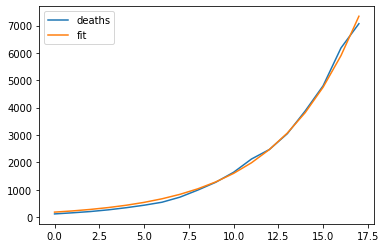

In [224]:
df_us[['deaths', 'fit']].plot()

In [225]:
df_us.shape

(18, 4)

In [243]:
x = np.random.rand(2, 1000)

In [ ]:
scipy.stats.invgamma.pdf()

In [251]:
mu = 5.1
coef_var = .86
alpha = 

In [249]:
scipy.stats.gamma(5.1, .86)

In [313]:
def get_gamma_param(mean, coef_of_var):
    alpha = math.pow(1 / coef_of_var, 2)
    beta = alpha / mean
    return alpha, beta

In [314]:
get_gamma_param(5.1, .86)

(1.3520822065981613, 0.26511415815650224)

In [315]:
get_gamma_param(18.8, .45)

(4.938271604938272, 0.2626740215392698)

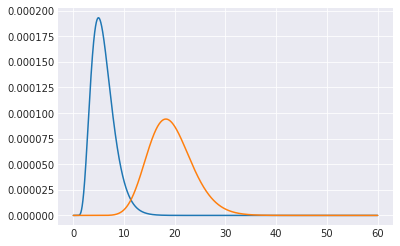

In [318]:
delta = 1e-3
x = np.arange(0, 60, delta)

inf_to_onset = scipy.stats.gamma.pdf(x, 5.1, 0.86) * delta
onset_to_death = scipy.stats.gamma.pdf(x, 18.8, 0.45) * delta
plt.plot(x, inf_to_onset)
plt.plot(x, onset_to_death)

In [319]:
inf_to_death = signal.fftconvolve(inf_to_onset, onset_to_death, 'same') / delta

In [320]:
np.trapz(inf_to_death, x)

0.16155952454158476

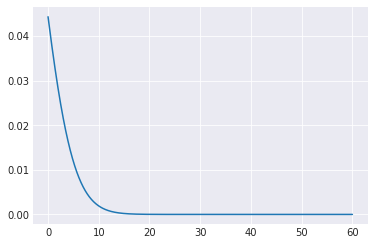

In [308]:
plt.plot(x, inf_to_death)

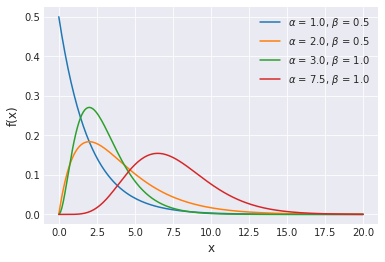

In [237]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 20, 200)
alphas = [1., 2., 3., 7.5]
betas = [.5, .5, 1., 1.]
for a, b in zip(alphas, betas):
    pdf = scipy.stats.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [226]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    # Group intercept
    a_grp = pm.Normal('a_grp', a[0], 1)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 1)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=1)
    
    # Priors for unknown model parameters
    # Group intercept
    b_grp = pm.Normal('b_grp', a[1], 1)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', 1)
    # Individual intercepts
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=1)

    sigma = pm.HalfNormal('sigma', 1, shape=1)
    
    # Likelihood (sampling distribution) of observations
    x = pm.Data("x", df_us['idx'].values)
    deaths = pm.Data("y", df_us['deaths'].astype('float64').values)
    
    pm.NegativeBinomial(
        'fit', 
        (a_ind * b_ind ** x), # Exponential regression
        sigma, 
        observed=deaths)

In [228]:
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=1, target_accept=.9)
    
#     # Update data so that we get predictions into the future
#     for country in countries:
#         df_country = df_sign.loc[lambda x: (x.country == country)]
#         x_data = np.arange(0, 30)
#         y_data = np.array([np.nan] * len(x_data))
#         pm.set_data({country + "x_data": x_data})
#         pm.set_data({country + "y_data": y_data})
    
    # Sample posterior predictive
    x_data = np.arange(df_us.shape[0] + 14)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x": x_data})
    pm.set_data({"y": x_data})
    
    post_pred = pm.sample_posterior_predictive(trace, samples=100)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
INFO:pymc3:NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling chain 0, 23 divergences: 100%|██████████| 2000/2000 [00:14<00:00, 135.70it/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks
/home/benson/fpna/.virtualenvs/fpna/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains

Text(0.5, 0.98, 'Posterior of daily growth')

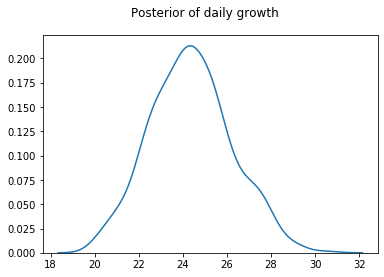

In [229]:
fig, axs = plt.subplots(nrows=1)
sns.distplot((trace['b_ind'] * 100) - 100, hist=False)
ax.set_xlabel('Daily growth in %')
plt.suptitle('Posterior of daily growth')

In [230]:
post_pred.keys()

dict_keys(['fit'])

In [231]:
post_pred['fit'].shape

(100, 32)

In [232]:
post_pred['fit']

array([[   311,     99,    237, ..., 218194, 106422, 129111],
       [   232,    116,    113, ...,  40700, 146345, 503504],
       [   216,    263,    466, ...,  59200,  38381,  22671],
       ...,
       [   367,    249,    573, ..., 156054, 150121, 283543],
       [   261,    170,    138, ..., 180434, 111605, 329670],
       [   355,    217,    153, ...,  25392,  30219,  71516]])

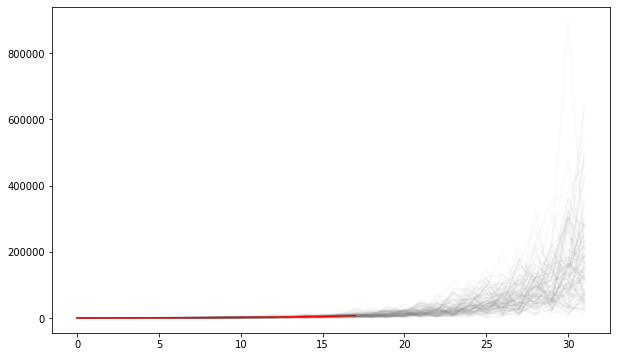

In [233]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(0, post_pred['fit'].shape[1]), post_pred['fit'].T, alpha=.05, color='.5')
ax.plot(df_us['idx'], df_us['deaths'], color='r')
plt.show()

## Other

In [64]:
def makePowerlawWithCutoff(alpha, kappa ):
    '''Create a model function for a powerlaw distribution with exponential cutoff.

    :param alpha: the exponent of the distribution
    :param kappa: the degree cutoff
    :returns: a model function'''
    C = Li(alpha, math.exp(-1.0 / kappa))
    def p( k ):
        return (pow((k + 0.0), -alpha) * math.exp(-(k + 0.0) / kappa)) / C
    return p

def generateFrom(N, p, maxdeg = 100 ):
    '''Generate a random graph with degree distribution described
    by a model function.

    :param N: number of numbers to generate
    :param p: model function
    :param maxdeg: maximum node degree we'll consider (defaults to 100)
    :returns: a network with the given degree distribution'''

    # construct degrees according to the distribution given
    # by the model function
    ns = []
    t = 0
    for i in range(N):
        while True:
            k = 1 + int (np.random.random() * (maxdeg - 1))
            if np.random.random() < p(k):
                ns = ns + [ k ]
                t = t + k
                break

    # if the sequence is odd, choose a random element
    # and increment it by 1 (this doesn't change the
    # distribution significantly, and so is safe)
    if t % 2 != 0:
        i = int(np.random.random() * len(ns))
        ns[i] = ns[i] + 1

    # populate the network using the configuration
    # model with the given degree distribution
    g = nx.configuration_model(ns, create_using = nx.Graph())
    g = g.subgraph(max(nx.connected_components(g), key = len)).copy()
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    return g

In [65]:
# https://www.pnas.org/content/107/51/22020
g = generateFrom(10000, makePowerlawWithCutoff(2.21, 1.1))

In [71]:
nx.degree(g)

DegreeView({2912: 1, 3940: 5, 614: 2, 551: 1, 9993: 2, 8428: 1, 7628: 2, 8880: 1, 6449: 1, 6521: 3, 925: 1})

In [68]:
m = SIR()

f = SynchronousDynamics(m, g)
rc = f.set(param).run()

In [69]:
rc[epyc.Experiment.RESULTS]

{'S': 11, 'I': 0, 'R': 0}

In [49]:
# create a notebook for results and a lab in which to run the experiments
nb = epyc.JSONLabNotebook('sir-experiments.json')
lab = epyc.Lab(nb)

# build the parameter space, where P_INFECT ranges from 0.01 to 1.0 in 10 steps
lab[SIR.P_INFECTED] = 0.01
lab[SIR.P_INFECT] = np.linspace(0.01, 1.0, num = 10, endpoint = True)
lab[SIR.P_REMOVE] = 0.05

# run 5 repetitions of the experiment at each point in the parameter space
lab.runExperiment(epyc.RepeatedExperiment(e, 5))

KeyboardInterrupt: 

In [ ]:
df = lab.dataframe()

## Tensorflow

In [388]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [385]:
def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow_core._api.v2.config' from '/home/benson/fpna/.virtualenvs/fpna/lib/python3.7/site-packages/tensorflow_core/_api/v2/config/__init__.py'>

In [387]:
ifr = .01

In [328]:
def get_gamma_param(mean, coef_of_var):
    alpha = math.pow(1 / coef_of_var, 2)
    beta = alpha / mean
    return alpha, beta

In [370]:
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf
inf_to_onset_alpha, inf_to_onset_beta = get_gamma_param(5.1, .86)
onset_to_death_alpha, onset_to_death_beta = get_gamma_param(18.8, .45)

# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
# Fifty-nine of the 468 reports indicate that the infectee had symptoms earlier than the infector. Thus, presymptomatic transmission might be occurring. Given these negative-valued serial intervals, COVID-19 serial intervals seem to resemble a normal distribution more than the commonly assumed gamma or Weibull distributions (4,5), which are limited to positive values (Appendix)
# serial_interval_mean, serial_interval_sdev = 3.96, 4.75

serial_interval_alpha, serial_interval_beta = get_gamma_param(6.5, .62)

In [482]:
n_sample = 1e5
inf_to_onset = tfd.Gamma(inf_to_onset_alpha, inf_to_onset_beta).sample(n_sample)
onset_to_death = tfd.Gamma(onset_to_death_alpha, onset_to_death_beta).sample(n_sample)

In [483]:
inf_to_death = inf_to_onset + onset_to_death

ifr_dist = tf.math.multiply(tf.cast(ifr * tf.cast(tf.size(inf_to_death), dtype=tf.float32) > 
                   tf.cast(tf.range(tf.size(inf_to_death)), dtype=tf.float32), 
                   dtype=tf.float32), inf_to_death)

In [504]:
serial_interval = tfd.Gamma(serial_interval_alpha, serial_interval_beta).sample(n_sample)

serial_interval_discrete = []
bkt = np.append(np.array(0), np.arange(1.5, 51, 1))
for i, j in zip(bkt[:-1], bkt[1:]):
    serial_interval_discrete.append(np.sum((serial_interval >= i) & (serial_interval < j)))
    
print(f"Serial interval probability sum check: {np.sum([np.array(serial_interval_discrete) / n_sample])}")
serial_interval_discrete = tfd.Categorical(
    probs=[np.flip(np.array(serial_interval_discrete) / n_sample)])

Serial interval probability sum: 1.0


In [ ]:
def joint_log_prob(deaths):
    rv_inf_to_onset = tfd.Gamma(inf_to_onset_alpha, inf_to_onset_beta)
    rv_onset_to_death = tfd.Gamma(onset_to_death_alpha, onset_to_death_beta)
    
    rv_ifr_dist = tf.math.multiply(tf.cast(ifr * tf.cast(tf.size(inf_to_death), dtype=tf.float32) > 
                                        tf.cast(tf.range(tf.size(inf_to_death)), dtype=tf.float32), 
                                        dtype=tf.float32), inf_to_death)
    
#     tfp.sts.Autoregressive(51, coefficients_prior=serial_interval_discrete)
    
    

Text(0.5, 1.0, 'Infection to Death Distribution')

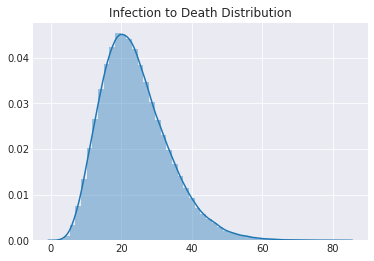

In [456]:
sns.distplot(inf_to_death).set_title('Infection to Death Distribution')

Text(0.5, 1.0, 'Infection to Death Distribution')

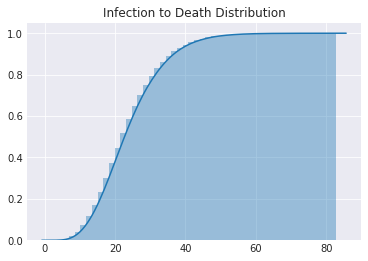

In [457]:
sns.distplot(inf_to_death, hist_kws={'cumulative': True}, kde_kws={'cumulative': True}).set_title('Infection to Death Distribution')



In [413]:
death_dist = inf_to_death * ifr_dist

Text(0.5, 1.0, 'Serial Interval Distribution')

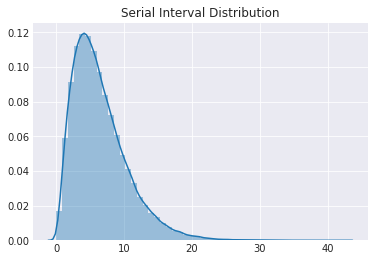

In [459]:
sns.distplot(serial_interval).set_title('Serial Interval Distribution')

In [460]:
serial_interval

<tf.Tensor: shape=(100000,), dtype=float32, numpy=
array([ 8.817837  ,  0.66616696,  4.751441  , ..., 12.730528  ,
        6.649432  ,  4.9314356 ], dtype=float32)>

## Fit rate

In [555]:
growth_rate = ((df_us['deaths'] / df_us['deaths'].shift(1)) - 1).dropna()
x = np.array(growth_rate.index).reshape(-1, 1)
y = np.array(growth_rate.values)

In [556]:
x_tst = np.arange(1, 50).reshape(-1, 1)

In [557]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [626]:
df_ca = df[df['state/region'] == 'NY'].groupby('date', as_index=False)['deceased_pct1M'].sum()
df_ca = df_ca[df_ca['deceased_pct1M'] > 0.2]

In [627]:
df_ca['growth'] = (df_ca['deceased_pct1M'] / df_ca['deceased_pct1M'].shift(1) - 1)
df_ca.dropna(inplace=True)

In [628]:
x = np.arange(len(df_ca)).reshape(-1, 1)
y = df_ca['growth'].values

In [629]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

# Make predictions.
yhat = model(x_tst)

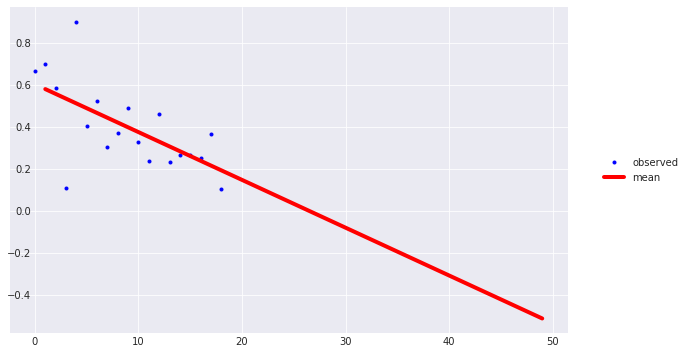

In [630]:
#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=(10, 6))  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
# plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
# plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))